**The purpose** of this model is to mitigate misinformation in videos on the TikTok platform.

**The goal** of this model is to predict whether a TikTok video presents a "claim" or presents an "opinion".

### **Task 1. Imports and data loading**

In [1]:
# Import packages for data manipulation
import pandas as pd
import numpy as np

# Import packages for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import packages for data preprocessing
from sklearn.feature_extraction.text import CountVectorizer

# Import packages for data modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, \
recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

# Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Loading the dataset into a dataframe
data = pd.read_csv('/content/drive/My Drive/01_Projects/02_TikTok/tiktok_dataset.csv')


### **Task 2: Examine data, summary info, and descriptive stats**

In [3]:
# Display first few rows
data.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


In [4]:
# Get number of rows and columns
data.shape

(19382, 12)

In [5]:
# Get basic information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19382 entries, 0 to 19381
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   #                         19382 non-null  int64  
 1   claim_status              19084 non-null  object 
 2   video_id                  19382 non-null  int64  
 3   video_duration_sec        19382 non-null  int64  
 4   video_transcription_text  19084 non-null  object 
 5   verified_status           19382 non-null  object 
 6   author_ban_status         19382 non-null  object 
 7   video_view_count          19084 non-null  float64
 8   video_like_count          19084 non-null  float64
 9   video_share_count         19084 non-null  float64
 10  video_download_count      19084 non-null  float64
 11  video_comment_count       19084 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 1.8+ MB


In [6]:
# Generate basic descriptive stats
data.describe()

,#,video_id,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
count,19382.000000,1.938200e+04,19382.000000,19084.000000,19084.000000,19084.000000,19084.000000,19084.000000
mean,9691.500000,5.627454e+09,32.421732,254708.558688,84304.636030,16735.248323,1049.429627,349.312146
std,5595.245794,2.536440e+09,16.229967,322893.280814,133420.546814,32036.174350,2004.299894,799.638865
min,1.000000,1.234959e+09,5.000000,20.000000,0.000000,0.000000,0.000000,0.000000
25%,4846.250000,3.430417e+09,18.000000,4942.500000,810.750000,115.000000,7.000000,1.000000
50%,9691.500000,5.618664e+09,32.000000,9954.500000,3403.500000,717.000000,46.000000,9.000000
75%,14536.750000,7.843960e+09,47.000000,504327.000000,125020.000000,18222.000000,1156.250000,292.000000
max,19382.000000,9.999873e+09,60.000000,999817.000000,657830.000000,256130.000000,14994.000000,9599.000000


In [7]:
# Check for missing values
data.isna().sum()

#                             0
claim_status                298
video_id                      0
video_duration_sec            0
video_transcription_text    298
verified_status               0
author_ban_status             0
video_view_count            298
video_like_count            298
video_share_count           298
video_download_count        298
video_comment_count         298
dtype: int64

**Note:** There are very few missing values relative to the number of samples in the dataset. Therefore, observations with missing values can be dropped.

In [8]:
# Drop rows with missing values
data = data.dropna(axis=0)

In [9]:
# Check for duplicates
data.duplicated().sum()

0

In [10]:
# Check class balance
data["claim_status"].value_counts(normalize=True)

claim      0.503458
opinion    0.496542
Name: claim_status, dtype: float64

**Note:** Approximately 50.3% of the dataset represents claims and 49.7% represents opinions, so the outcome variable is balanced.

### **Task 3. Feature engineering**


Extract the length (character count) of each `video_transcription_text` and add this to the dataframe as a new column called `text_length` so that it can be used as a feature in the model.

In [11]:
# Create `text_length` column
data['text_length'] = data['video_transcription_text'].str.len()
data.head()

<ipython-input-11-032ace4936dd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['text_length'] = data['video_transcription_text'].str.len()


,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0,97
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0,107
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0,137
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0,131
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0,128


In [12]:
# Calculate the average `text_length` for claims and opinions.
data[['claim_status', 'text_length']].groupby('claim_status').mean()

,text_length
claim_status,
claim,95.376978
opinion,82.722562


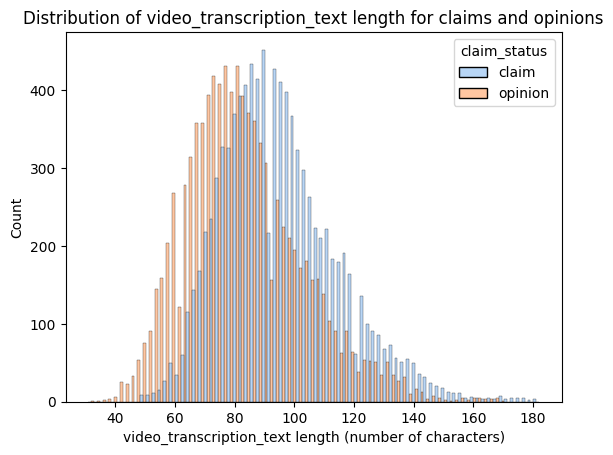

In [13]:
# Visualize the distribution of `text_length` for claims and opinions
# Create two histograms in one plot

sns.histplot(data=data, stat="count", multiple="dodge", x="text_length",
             kde=False, palette="pastel", hue="claim_status",
             element="bars", legend=True)
plt.xlabel("video_transcription_text length (number of characters)")
plt.ylabel("Count")
plt.title("Distribution of video_transcription_text length for claims and opinions")
plt.show()

Letter count distributions for both claims and opinions are approximately normal with a slight right skew. Claim videos tend to have more characters&mdash;about 13 more on average, as indicated in a previous cell.

**Feature selection and transformation**

Encode target and catgorical variables.

In [14]:
X = data.copy()
# Drop unnecessary columns
X = X.drop(['#', 'video_id'], axis=1)
# Encode target variable
X['claim_status'] = X['claim_status'].replace({'opinion': 0, 'claim': 1})
# Dummy encode remaining categorical values
X = pd.get_dummies(X,
                   columns=['verified_status', 'author_ban_status'],
                   drop_first=True)
X.head()

,claim_status,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,1,59,someone shared with me that drone deliveries a...,343296.0,19425.0,241.0,1.0,0.0,97,0,0,1
1,1,32,someone shared with me that there are more mic...,140877.0,77355.0,19034.0,1161.0,684.0,107,0,0,0
2,1,31,someone shared with me that american industria...,902185.0,97690.0,2858.0,833.0,329.0,137,0,0,0
3,1,25,someone shared with me that the metro of st. p...,437506.0,239954.0,34812.0,1234.0,584.0,131,0,0,0
4,1,19,someone shared with me that the number of busi...,56167.0,34987.0,4110.0,547.0,152.0,128,0,0,0


### **Task 4. Split the data**

In [15]:
# Isolate target variable
y = X['claim_status']

# Isolate features
X = X.drop(['claim_status', 'video_transcription_text'], axis=1)

#### **Task 5: Create train/validate/test sets**

In [16]:
# Split the data into training and testing sets
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [17]:
# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.25, random_state=0)

In [18]:
# Get shape of each training, validation, and testing set
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((11450, 10), (3817, 10), (3817, 10), (11450,), (3817,), (3817,))

### **Task 6. Build models**

### **Build a random forest model**

In [19]:
# Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=0)

# Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [5, 7, None],
             'max_features': [0.3, 0.6],
            #  'max_features': 'auto'
             'max_samples': [0.7],
             'min_samples_leaf': [1,2],
             'min_samples_split': [2,3],
             'n_estimators': [75,100,200],
             }

# Define a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='f1')

In [20]:
%%time
rf_cv.fit(X_train, y_train)

CPU times: user 7min 23s, sys: 1.21 s, total: 7min 24s
Wall time: 8min 27s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [5, 7, None], 'max_features': [0.3, 0.6],
                         'max_samples': [0.7], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [75, 100, 200]},
             refit='f1', scoring={'precision', 'accuracy', 'recall', 'f1'})

In [21]:
# Examine best recall score
rf_cv.best_score_

0.9951433900450615

In [22]:
# Examine best parameters
rf_cv.best_params_

{'max_depth': 5,
 'max_features': 0.6,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 75}

**Note:**

This model performs exceptionally well, with an average recall score of 0.995 across the five cross-validation folds. After checking the precision score to be sure the model is not classifying all samples as claims, it is clear that this model is making almost perfect classifications.

### **Build an XGBoost model**

In [23]:
# Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=0)

# Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [4,8,12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300, 500]
             }

# Define a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='f1')

In [24]:
%%time
xgb_cv.fit(X_train, y_train)

CPU times: user 2min 3s, sys: 1.43 s, total: 2min 4s
Wall time: 1min 16s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=0, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [4, 8, 12],
                         'min_child_weight': [3, 5],
                         'n_estimators': [300, 500]},
             refit='f1', scoring={'precision', 'accuracy', 'recall', 'f1'})

In [25]:
xgb_cv.best_score_

0.9946195505955426

**Note:**

This model also performs exceptionally well. Although its recall score is very slightly lower than the random forest model's, its precision score is perfect.

### **Task 7. Evaluate models**

Evaluate models against validation data.


#### **Random forest**

In [27]:
# Use the random forest "best estimator" model to get predictions on the validation set
y_pred = rf_cv.best_estimator_.predict(X_val)

In [28]:
# Display the predictions on the validation set
y_pred

array([1, 0, 1, ..., 1, 1, 1])

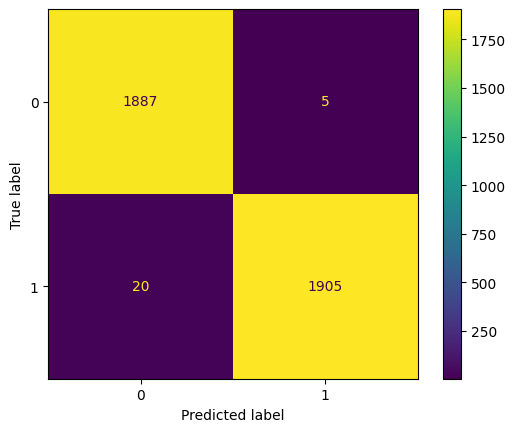

In [29]:
# Create a confusion matrix to visualize the results of the classification model

# Compute values for confusion matrix
log_cm = confusion_matrix(y_val, y_pred)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.show()

In [31]:
# Create a classification report
# Create classification report for random forest model
target_labels = ['opinion', 'claim']
print(classification_report(y_val, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

     opinion       0.99      1.00      0.99      1892
       claim       1.00      0.99      0.99      1925

    accuracy                           0.99      3817
   macro avg       0.99      0.99      0.99      3817
weighted avg       0.99      0.99      0.99      3817



**Note:**

The classification report above shows that the random forest model scores were nearly perfect. The confusion matrix indicates that there were 25 misclassifications&mdash;five false postives and twenty false negatives.

#### **XGBoost**

In [32]:
#Evaluate XGBoost model
y_pred = xgb_cv.best_estimator_.predict(X_val)

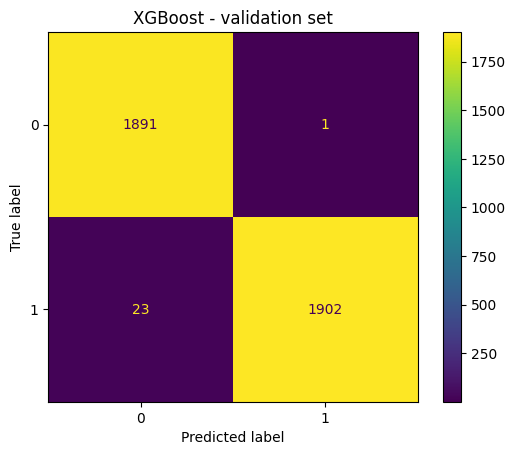

In [33]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_val, y_pred)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.title('XGBoost - validation set');
plt.show()


In [34]:
# Create a classification report
target_labels = ['opinion', 'claim']
print(classification_report(y_val, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

     opinion       0.99      1.00      0.99      1892
       claim       1.00      0.99      0.99      1925

    accuracy                           0.99      3817
   macro avg       0.99      0.99      0.99      3817
weighted avg       0.99      0.99      0.99      3817



**Note:**

The results of the XGBoost model were also nearly perfect.The confusion matrix indicates that there were 24 misclassifications&mdash;1 false postives and twenty-three false negatives.

### **Use champion model to predict on test data**

Both random forest and XGBoost model architectures resulted in nearly perfect models. Nonetheless, in this case XGBoost  performed a little bit better, so it is the champion model.

Now, use the champion model to predict on the test data.

In [35]:
# Use champion model to predict on test data
y_pred = xgb_cv.best_estimator_.predict(X_test)

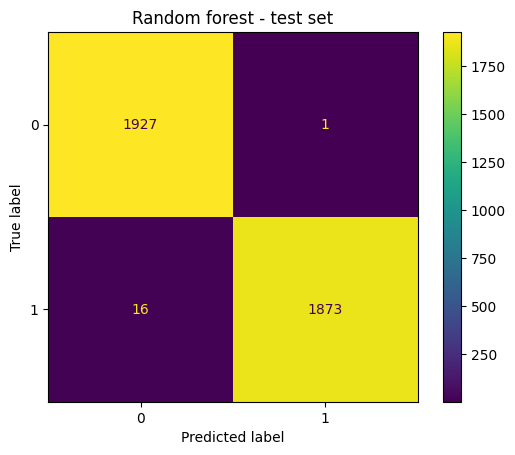

In [36]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_test, y_pred)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.title('Random forest - test set');
plt.show()

#### **Feature importances of champion model**



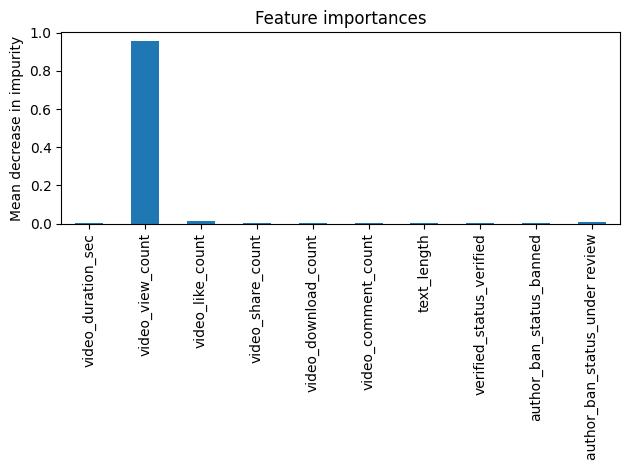

In [37]:
importances = xgb_cv.best_estimator_.feature_importances_
rf_importances = pd.Series(importances, index=X_test.columns)

fig, ax = plt.subplots()
rf_importances.plot.bar(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()